# Imports

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance
import ta

from tqdm.notebook import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.metrics import f1_score
from imblearn.under_sampling import RandomUnderSampler
pd.set_option('display.float_format', lambda x: '%.3f' % x)
np.set_printoptions(suppress=True)
from pprint import pprint

import gc
import optuna
from sklearn.feature_selection import RFE


/tmp/ipykernel_20287/384002432.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df = pd.read_csv('Data/Training/pair_features_1_pairs1_300_120.csv')
df.head()

,Ticker_P1,Date,High_P1,Low_P1,Volume_P1,Close_P1,Ticker_P2,High_P2,Low_P2,Volume_P2,Close_P2,abs_spread,abs_spread_mean,abs_spread_std,abs_spread_mean_MA,abs_spread_std_MA,pnls,actual_abs_spread,actual_abs_spread_std
0,AMAT,2001-02-09 00:00:00,22.531,21.000,32504200.000,15.688,BLK,43.000,42.200,27200.000,26.388,10.699,12.463,5.885,9.995,1.121,0.000,10.051,1.299
1,AMAT,2001-02-12 00:00:00,22.500,21.102,28449600.000,16.194,BLK,43.710,42.000,33100.000,27.132,10.937,12.472,5.881,10.427,0.934,0.000,9.409,1.482
2,AMAT,2001-02-13 00:00:00,22.500,20.500,42626000.000,15.182,BLK,43.990,43.140,33900.000,27.263,12.081,12.481,5.879,11.068,0.666,0.000,8.484,0.821
3,AMAT,2001-02-14 00:00:00,23.844,21.000,95765800.000,17.229,BLK,43.460,42.500,20800.000,26.950,9.721,12.484,5.877,10.946,0.862,0.000,7.973,0.675
4,AMAT,2001-02-15 00:00:00,25.312,23.719,55611800.000,18.196,BLK,43.500,42.700,18400.000,27.138,8.942,12.481,5.879,10.476,1.200,0.000,7.627,0.514


In [3]:
df['pnls'] = df['pnls']*100.0
# df = df[df.pnls != 0]

In [4]:
total_days = df.Date.nunique()
total_days

5753

In [5]:
# df.dropna()

In [6]:
df.pnls.describe()

count   5753.000
mean      -0.010
std        0.660
min       -8.384
25%        0.000
50%        0.000
75%        0.000
max        8.927
Name: pnls, dtype: float64

## Technical Indicators

In [7]:
df

,Ticker_P1,Date,High_P1,Low_P1,Volume_P1,Close_P1,Ticker_P2,High_P2,Low_P2,Volume_P2,Close_P2,abs_spread,abs_spread_mean,abs_spread_std,abs_spread_mean_MA,abs_spread_std_MA,pnls,actual_abs_spread,actual_abs_spread_std
0,AMAT,2001-02-09 00:00:00,22.531,21.000,32504200.000,15.688,BLK,43.000,42.200,27200.000,26.388,10.699,12.463,5.885,9.995,1.121,0.000,10.051,1.299
1,AMAT,2001-02-12 00:00:00,22.500,21.102,28449600.000,16.194,BLK,43.710,42.000,33100.000,27.132,10.937,12.472,5.881,10.427,0.934,0.000,9.409,1.482
2,AMAT,2001-02-13 00:00:00,22.500,20.500,42626000.000,15.182,BLK,43.990,43.140,33900.000,27.263,12.081,12.481,5.879,11.068,0.666,0.000,8.484,0.821
3,AMAT,2001-02-14 00:00:00,23.844,21.000,95765800.000,17.229,BLK,43.460,42.500,20800.000,26.950,9.721,12.484,5.877,10.946,0.862,0.000,7.973,0.675
4,AMAT,2001-02-15 00:00:00,25.312,23.719,55611800.000,18.196,BLK,43.500,42.700,18400.000,27.138,8.942,12.481,5.879,10.476,1.200,0.000,7.627,0.514
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5748,AMAT,2023-12-15 00:00:00,164.210,161.490,8577200.000,161.676,BLK,819.000,789.470,2702600.000,819.000,657.324,548.734,43.055,623.912,26.471,0.000,637.376,2.791
5749,AMAT,2023-12-18 00:00:00,161.350,157.730,4772300.000,160.089,BLK,815.000,795.800,916300.000,796.440,636.351,549.355,42.968,631.676,22.138,0.000,638.627,3.389
5750,AMAT,2023-12-19 00:00:00,162.730,160.020,4958200.000,162.055,BLK,814.420,798.950,756400.000,801.380,639.325,549.992,42.882,639.074,14.869,0.000,640.626,5.500
5751,AMAT,2023-12-20 00:00:00,162.000,156.830,5488700.000,156.655,BLK,805.410,788.840,547900.000,789.230,632.575,550.642,42.649,642.248,9.693,0.000,644.424,5.177


### Beta

In [8]:
def compute_beta(rs,df,ticker,market):
    rows = df.loc[rs.index]
    sec_returns = np.log( df[[ticker,market]] / df[[ticker,market]].shift(1) ) 

    cov = sec_returns.cov() * 250
    cov_with_market = cov.iloc[0,1]
    market_var = sec_returns[market].var() * 250
    beta = cov_with_market / market_var
    return beta

In [9]:
all_tickers = df['Ticker_P1'].unique().tolist()+df['Ticker_P2'].unique().tolist()
len(all_tickers)

2

### Single Ticker Features

In [10]:
df.columns

Index(['Ticker_P1', 'Date', 'High_P1', 'Low_P1', 'Volume_P1', 'Close_P1',
       'Ticker_P2', 'High_P2', 'Low_P2', 'Volume_P2', 'Close_P2', 'abs_spread',
       'abs_spread_mean', 'abs_spread_std', 'abs_spread_mean_MA',
       'abs_spread_std_MA', 'pnls', 'actual_abs_spread',
       'actual_abs_spread_std'],
      dtype='object')

In [11]:
df.sort_values('Date')

,Ticker_P1,Date,High_P1,Low_P1,Volume_P1,Close_P1,Ticker_P2,High_P2,Low_P2,Volume_P2,Close_P2,abs_spread,abs_spread_mean,abs_spread_std,abs_spread_mean_MA,abs_spread_std_MA,pnls,actual_abs_spread,actual_abs_spread_std
0,AMAT,2001-02-09 00:00:00,22.531,21.000,32504200.000,15.688,BLK,43.000,42.200,27200.000,26.388,10.699,12.463,5.885,9.995,1.121,0.000,10.051,1.299
1,AMAT,2001-02-12 00:00:00,22.500,21.102,28449600.000,16.194,BLK,43.710,42.000,33100.000,27.132,10.937,12.472,5.881,10.427,0.934,0.000,9.409,1.482
2,AMAT,2001-02-13 00:00:00,22.500,20.500,42626000.000,15.182,BLK,43.990,43.140,33900.000,27.263,12.081,12.481,5.879,11.068,0.666,0.000,8.484,0.821
3,AMAT,2001-02-14 00:00:00,23.844,21.000,95765800.000,17.229,BLK,43.460,42.500,20800.000,26.950,9.721,12.484,5.877,10.946,0.862,0.000,7.973,0.675
4,AMAT,2001-02-15 00:00:00,25.312,23.719,55611800.000,18.196,BLK,43.500,42.700,18400.000,27.138,8.942,12.481,5.879,10.476,1.200,0.000,7.627,0.514
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5748,AMAT,2023-12-15 00:00:00,164.210,161.490,8577200.000,161.676,BLK,819.000,789.470,2702600.000,819.000,657.324,548.734,43.055,623.912,26.471,0.000,637.376,2.791
5749,AMAT,2023-12-18 00:00:00,161.350,157.730,4772300.000,160.089,BLK,815.000,795.800,916300.000,796.440,636.351,549.355,42.968,631.676,22.138,0.000,638.627,3.389
5750,AMAT,2023-12-19 00:00:00,162.730,160.020,4958200.000,162.055,BLK,814.420,798.950,756400.000,801.380,639.325,549.992,42.882,639.074,14.869,0.000,640.626,5.500
5751,AMAT,2023-12-20 00:00:00,162.000,156.830,5488700.000,156.655,BLK,805.410,788.840,547900.000,789.230,632.575,550.642,42.649,642.248,9.693,0.000,644.424,5.177


In [12]:
df.columns

Index(['Ticker_P1', 'Date', 'High_P1', 'Low_P1', 'Volume_P1', 'Close_P1',
       'Ticker_P2', 'High_P2', 'Low_P2', 'Volume_P2', 'Close_P2', 'abs_spread',
       'abs_spread_mean', 'abs_spread_std', 'abs_spread_mean_MA',
       'abs_spread_std_MA', 'pnls', 'actual_abs_spread',
       'actual_abs_spread_std'],
      dtype='object')

In [13]:
label = 'actual_abs_spread'
exclude = ['pnls', 'High_P1', 'High_P2', 'Low_P1', 'Low_P2', 'abs_spread', 'abs_spread_mean', 'abs_spread_std', 'actual_abs_spread_std']
X = df
y = df[label]

X = X.drop(['Date', 'Ticker_P1', 'Ticker_P2', 'Volume_P1', 'Volume_P2', label],axis=1)
X = X.drop(exclude, axis=1)

In [14]:
X = X.dropna()
X['abs_spread_log_mean_MA'] = np.log(X['abs_spread_mean_MA'])
X['abs_spread_log_std_mean_MA'] = np.log(X['abs_spread_std_MA'])
X = X.drop(['abs_spread_mean_MA', 'abs_spread_std_MA'],axis=1)
X

,Close_P1,Close_P2,abs_spread_log_mean_MA,abs_spread_log_std_mean_MA
0,15.688,26.388,2.302,0.114
1,16.194,27.132,2.344,-0.068
2,15.182,27.263,2.404,-0.407
3,17.229,26.950,2.393,-0.149
4,18.196,27.138,2.349,0.182
...,...,...,...,...
5748,161.676,819.000,6.436,3.276
5749,160.089,796.440,6.448,3.097
5750,162.055,801.380,6.460,2.699
5751,156.655,789.230,6.465,2.271


In [15]:
y = np.log(y)
y.describe()

count   5753.000
mean       4.862
std        1.246
min       -0.039
25%        4.366
50%        4.948
75%        5.822
max        6.630
Name: actual_abs_spread, dtype: float64

## Train test split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42,shuffle=False)

In [17]:
print(df.loc[X_train.index].Date.min(),df.loc[X_train.index].Date.max())

2001-02-09 00:00:00 2019-05-29 00:00:00


In [18]:
print(df.loc[X_val.index].Date.min(),df.loc[X_val.index].Date.max())

2019-05-30 00:00:00 2021-09-08 00:00:00


In [19]:
print(df.loc[X_test.index].Date.min(),df.loc[X_test.index].Date.max())

2021-09-09 00:00:00 2023-12-21 00:00:00


## LSTM Model

In [20]:
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Dropout
#Creating the LSTM model
class lstm(Model):
    def __init__(self, in_shape):
        super(lstm, self).__init__()
        self.shape = in_shape
        self.lstm = LSTM(512, input_shape=self.shape, dropout=0.2, return_sequences = True)
        self.dropout = Dropout(0.2)
        self.dense = Dense(1)

    def call(self, x):
        x = self.lstm(x)
#         x = self.dropout(x)
        x = self.dense(x)
        return x

2024-03-20 06:33:07.600125: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-20 06:33:08.337839: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [21]:
# Reshape X for model training
trainX = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1])).astype(np.float32)
valX = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1])).astype(np.float32)
testX = np.reshape(X_test, ( X_test.shape[0], 1, X_test.shape[1])).astype(np.float32)

In [22]:
trainX.shape

(4602, 1, 4)

In [23]:
#initializing the lstm model
import tensorflow as tf
callback = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=5,\
                                            min_delta=0.001,restore_best_weights=True,verbose=1)

lstm_model = lstm((trainX.shape[0], 1, trainX.shape[1]))
lstm_model.compile(loss='mae', 
                   optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), metrics=['mae'])
#fitting the model
history = lstm_model.fit(
                    trainX, 
                    y_train,
                    validation_data=(valX, y_val), 
                    epochs=20, 
                    batch_size=32,
                    verbose=1, 
                    callbacks=callback,
                    shuffle=False)       

Epoch 1/20


2024-03-20 06:33:09.156358: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


144/144 [==============================] - 4s 15ms/step - loss: 0.5504 - mae: 0.5504 - val_loss: 0.2499 - val_mae: 0.2499
Epoch 2/20
144/144 [==============================] - 2s 12ms/step - loss: 0.3857 - mae: 0.3857 - val_loss: 0.2137 - val_mae: 0.2137
Epoch 3/20
144/144 [==============================] - 2s 12ms/step - loss: 0.3233 - mae: 0.3233 - val_loss: 0.2142 - val_mae: 0.2142
Epoch 4/20
144/144 [==============================] - 2s 12ms/step - loss: 0.3076 - mae: 0.3076 - val_loss: 0.2046 - val_mae: 0.2046
Epoch 5/20
144/144 [==============================] - 2s 12ms/step - loss: 0.3072 - mae: 0.3072 - val_loss: 0.2082 - val_mae: 0.2082
Epoch 6/20
144/144 [==============================] - 2s 12ms/step - loss: 0.2767 - mae: 0.2767 - val_loss: 0.2049 - val_mae: 0.2049
Epoch 7/20
144/144 [==============================] - 2s 12ms/step - loss: 0.2633 - mae: 0.2633 - val_loss: 0.2022 - val_mae: 0.2022
Epoch 8/20
144/144 [==============================] - 2s 12ms/step - loss: 0.269

In [24]:
lstm_model.summary()

Model: "lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               multiple                  1058816   
                                                                 
 dropout (Dropout)           multiple                  0 (unused)
                                                                 
 dense (Dense)               multiple                  513       
                                                                 
Total params: 1059329 (4.04 MB)
Trainable params: 1059329 (4.04 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


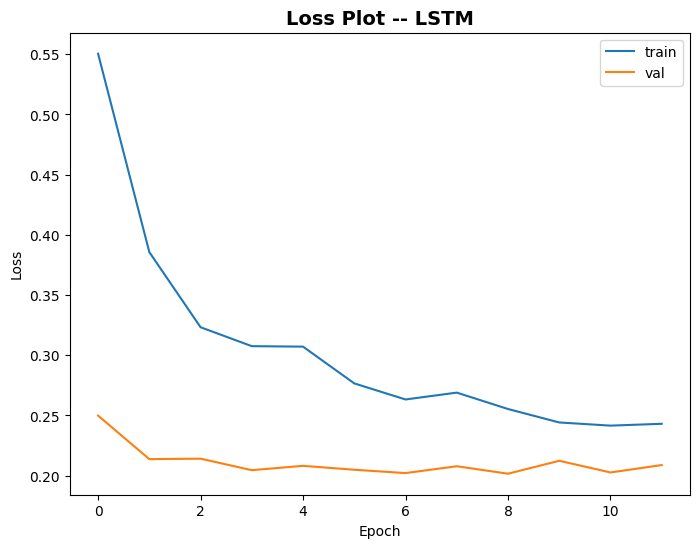

In [25]:
# Plot line graph to show amount loss according the the epoch
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Loss Plot -- LSTM', fontsize=14, color="black", fontweight="bold")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [26]:
inference_result = lstm_model.predict(testX).flatten()

18/18 [==============================] - 0s 2ms/step


count   576.000
mean      6.341
std       0.123
min       6.104
25%       6.252
50%       6.317
75%       6.407
max       6.630
Name: actual_abs_spread, dtype: float64

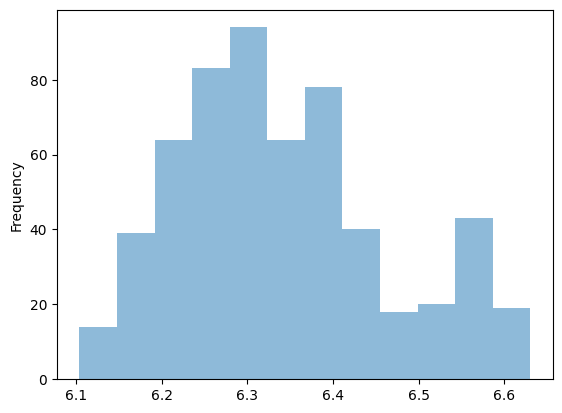

In [27]:
y_test.plot.hist(bins=12, alpha=0.5)
y_test.describe()

count   576.000
mean      6.116
std       0.007
min       6.103
25%       6.112
50%       6.114
75%       6.118
max       6.134
dtype: float64

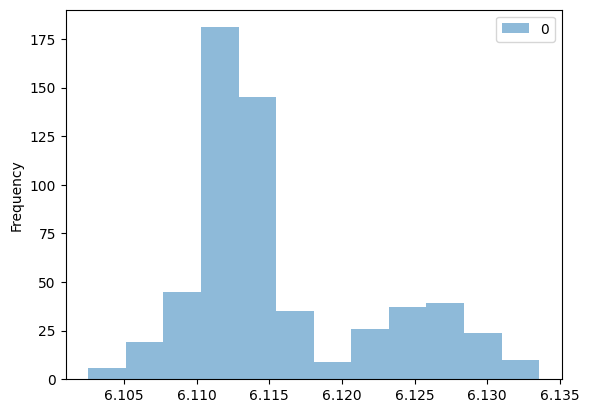

In [28]:
pd.DataFrame(inference_result).plot.hist(bins=12, alpha=0.5)
pd.Series(inference_result).describe()

In [29]:
lstm_mae = (inference_result[:len(y_test)] - y_test).abs().mean()
lstm_mae

0.2250469165449915

In [30]:
inference_result

array([6.1135445, 6.113562 , 6.113605 , 6.113648 , 6.1136622, 6.1138916,
       6.11379  , 6.1135964, 6.113634 , 6.1137886, 6.1137986, 6.1138635,
       6.1139197, 6.1134696, 6.113349 , 6.1133337, 6.1133494, 6.1132116,
       6.1133146, 6.1132684, 6.1133113, 6.1132846, 6.113292 , 6.1132674,
       6.113379 , 6.1134768, 6.1134925, 6.1134996, 6.1135225, 6.1135125,
       6.113505 , 6.113548 , 6.1135535, 6.1135345, 6.1135135, 6.113566 ,
       6.1135774, 6.113603 , 6.113624 , 6.113642 , 6.113794 , 6.1139045,
       6.1138363, 6.113963 , 6.1137834, 6.1138697, 6.1139417, 6.114086 ,
       6.1142697, 6.114386 , 6.1149817, 6.11408  , 6.1138744, 6.1138396,
       6.113884 , 6.113781 , 6.114034 , 6.1139927, 6.1144986, 6.113837 ,
       6.113941 , 6.114031 , 6.114619 , 6.1145988, 6.1141872, 6.114117 ,
       6.1138263, 6.1139903, 6.114338 , 6.1138053, 6.1138206, 6.1138678,
       6.1141915, 6.114266 , 6.1145506, 6.115478 , 6.1148467, 6.1156983,
       6.1149178, 6.1147685, 6.1153646, 6.114865 , 

In [31]:
mae = lstm_mae / y_test.abs().mean()
mae

0.03549163462904394

In [37]:
# Generate the PNL from predicted spread
from pair_trading_foundations.data_generation import ExecutePairTrading

BacktestData = df.loc[X_test.index]

samples = BacktestData
samples = samples.drop(['Date', 'Ticker_P1', 'Ticker_P2', 'Volume_P1', 'Volume_P2', label],axis=1)
samples = samples.drop(exclude,axis=1)
samples['abs_spread_log_mean_MA'] = np.log(samples.abs_spread_mean_MA)
samples['abs_spread_log_std_mean_MA'] = np.log(samples.abs_spread_std_MA)
samples = samples.drop(['abs_spread_mean_MA', 'abs_spread_std_MA'],axis=1)

model_input = np.reshape(samples, (samples.shape[0], 1, samples.shape[1])).astype(np.float32)
inference_result = lstm_model.predict(model_input).flatten()
BacktestData['pred_abs_spread'] = np.exp(inference_result)
BacktestData['diff_abs_spread'] = BacktestData['pred_abs_spread'] - BacktestData['abs_spread_mean_MA']
BacktestData['z_score'] = (np.log(BacktestData['pred_abs_spread']) / BacktestData['abs_spread_std_MA'])
BacktestData = BacktestData.reset_index()
BacktestData

pnls = []
entry_signal = 2
exit_signal = 0.2
test_len = 50
for idx in range(BacktestData.shape[0]):
    if (idx > BacktestData.shape[0]-test_len-1):
        pnls.append(np.nan)
    else:
        current_row = BacktestData.loc[idx]
        result = ExecutePairTrading(current_row.pred_abs_spread,   # Use predicted spread
                                    current_row.abs_spread_std_MA, # Use current std deviation
                                    entry_signal=entry_signal,
                                    exit_signal=exit_signal
                                ).execute(
                                    # Forward window
                                    vec1=BacktestData.loc[(idx+1):(idx+test_len)]['Close_P1'].values,
                                    vec2=BacktestData.loc[(idx+1):(idx+test_len)]['Close_P2'].values,
                                    dates=BacktestData.loc[(idx+1):(idx+test_len)]['Date'].values,
                                    base_fund=100,
                                )

        pnls.append(result.final_pl_pct)

BacktestData['pnls'] = pnls
BacktestData = BacktestData.dropna()
BacktestData

strategy = BacktestData.loc[(abs(BacktestData['z_score']) > 0.95)]
strategy

18/18 [==============================] - 0s 2ms/step


,index,Ticker_P1,Date,High_P1,Low_P1,Volume_P1,Close_P1,Ticker_P2,High_P2,Low_P2,...,abs_spread_mean,abs_spread_std,abs_spread_mean_MA,abs_spread_std_MA,pnls,actual_abs_spread,actual_abs_spread_std,pred_abs_spread,diff_abs_spread,z_score
2,5179,AMAT,2021-09-13 00:00:00,141.300,137.560,8507600.000,136.438,BLK,924.200,906.000,...,584.468,89.562,732.918,5.686,-0.017,697.258,15.914,451.965,-280.952,1.075
14,5191,AMAT,2021-09-29 00:00:00,134.040,128.040,10730100.000,125.509,BLK,864.160,855.890,...,593.580,87.810,682.756,2.773,-0.043,662.116,4.092,451.849,-230.906,2.204
19,5196,AMAT,2021-10-06 00:00:00,128.180,125.720,7388700.000,123.796,BLK,837.810,820.960,...,596.848,86.641,662.116,4.575,-0.025,671.366,10.141,451.813,-210.303,1.336
20,5197,AMAT,2021-10-07 00:00:00,129.950,127.460,5761300.000,125.127,BLK,855.060,841.460,...,597.529,86.388,662.976,5.148,-0.036,679.983,18.155,451.832,-211.144,1.187
21,5198,AMAT,2021-10-08 00:00:00,128.790,125.870,6300500.000,123.503,BLK,846.660,836.580,...,598.215,86.148,664.018,6.233,-0.033,690.759,24.434,451.820,-212.198,0.981
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
510,5687,AMAT,2023-09-20 00:00:00,139.660,136.890,5806900.000,136.445,BLK,694.690,682.670,...,549.288,41.213,550.689,6.191,0.006,516.075,8.803,455.958,-94.730,0.989
517,5694,AMAT,2023-09-29 00:00:00,141.560,138.070,4447600.000,137.919,BLK,656.820,645.540,...,549.767,40.626,507.626,5.726,0.032,495.999,6.447,458.123,-49.504,1.070
518,5695,AMAT,2023-10-02 00:00:00,141.410,137.260,4896900.000,138.975,BLK,646.250,638.740,...,549.743,40.653,504.162,3.245,0.035,495.987,6.440,458.272,-45.890,1.888
524,5701,AMAT,2023-10-10 00:00:00,142.730,140.350,3342900.000,140.858,BLK,649.400,641.700,...,549.237,41.116,498.328,3.961,0.065,489.535,4.519,458.530,-39.798,1.547


count   163.000
mean     -0.027
std       0.046
min      -0.175
25%      -0.050
50%      -0.022
75%      -0.002
max       0.092
Name: pnls, dtype: float64

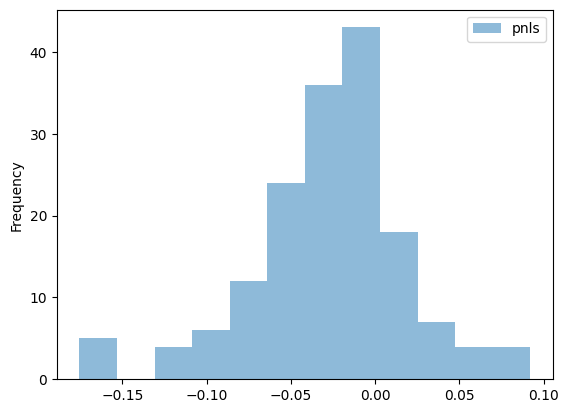

In [38]:
pd.DataFrame(strategy.pnls).plot.hist(bins=12, alpha=0.5)
pd.Series(strategy.pnls).describe()

In [39]:
# Normality test

from scipy.stats import shapiro
# normality test
stat, p = shapiro(inference_result)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.869, p=0.000
Sample does not look Gaussian (reject H0)


In [40]:
# D’Agostino’s K^2 Test
from scipy.stats import normaltest
# normality test
stat, p = normaltest(inference_result)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=68.627, p=0.000
Sample does not look Gaussian (reject H0)


In [36]:
# Anderson-Darling Test
from scipy.stats import anderson
result = anderson(inference_result)
print('Statistic: %.3f' % result.statistic)
p = 0
for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
if result.statistic < result.critical_values[i]:
    print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
else:
    print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

Statistic: 35.105
1.000: 1.085, data does not look normal (reject H0)
